In [3]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, mean_absolute_percentage_error
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Reading Data

In [4]:
df = pd.read_csv('data/raw/CRS_Data.csv',encoding='windows-1252')
df_dec5_pool = pd.read_csv('data/processed/CRS_Scores_as_of_DEC5.csv')

In [5]:
# df = df[~df['Draw #'].isin(['Draw #'])].copy()

In [6]:
df.head()

,ï»¿CRS Score,Date,Number of Invitations
0,460,"December 18, 2015",1503
1,461,"December 4, 2015",1451
2,472,"November 27, 2015",1559
3,484,"November 13, 2015",1506
4,489,"October 23, 2015",1502


In [7]:
df.rename(columns = {'ï»¿CRS Score' : 'CRS Score'}, inplace=True)
# df.rename(columns = {'Date of Draw' : 'Date', 'Minimum CRS Score Required' : 'CRS Score', '# of ITAs Issued' : 'Number of Invitations' }, inplace=True)

In [8]:
df.dtypes

CRS Score                object
Date                     object
Number of Invitations     int64
dtype: object

In [9]:
df

,CRS Score,Date,Number of Invitations
0,460,"December 18, 2015",1503
1,461,"December 4, 2015",1451
2,472,"November 27, 2015",1559
3,484,"November 13, 2015",1506
4,489,"October 23, 2015",1502
...,...,...,...
267,791 (*Provincial nominees only),"February 15, 2023",699
268,489 (*Foreign Skilled Worker Program nominees ...,"February 2, 2023",3300
269,733 (*Provincial nominees only),"February 1, 2023",893
270,490,"January 18, 2023",5500


In [10]:
df['CRS Score'].unique()

array(['460', '461', '472', '484', '489', '450', '459', '456', '471',
       '451', '463', '469', '482', '755', '453', '481', '735',
       '808 (*Canadian Experience Class only)', '818', '886', '475',
       '497', '786 (*Provincial nominees only)', '470', '483', '491',
       '538', '490', '488', '534', '468', '473', '457', '446', '452',
       '439', '458', '241 (*Federal Skilled Trades candidates only)',
       '673 (*Provincial nominees only)', '436', '438', '433', '435',
       '434', '441', '440', '449', '413',
       '199 (*Federal Skilled Trades candidates only)',
       '775 (*Provincial nominees only)', '415', '423', '431', '447',
       '445', '442', '284 (*Federal Skilled Trades candidates only)',
       '902 (*Provincial nominees only)',
       '288 (*Federal Skilled Trades candidates only)', '444',
       '357 (*Federal Skilled Trades candidates only)', '464', '462',
       '466', '465', '332 (*Federal Skilled Trades candidates only)',
       '454', '443', '478', '454 (*

# Data Cleaning & Preprocessing

In [11]:
df_clean = pd.DataFrame()

In [12]:
def preprocess_date(inp):
    if type(inp) == str:
        l = inp.split()
        if len(l[1]) > 2:
            day = l[:2]
        else:
            day = l[:1]
        try :
            Month,day,year = l[0],l[1],l[2]
            return pd.to_datetime(f"{Month} {day}, {year}")
        except Exception as e:
            print(e)

df_clean['Date'] = df['Date'].apply(preprocess_date)

In [13]:
import re
def preprocess(text):
    if (type(text) == str) :
        out = re.findall(r'\*(.*?)\)', text)
        if (len(text)> 3) & len(out) > 0 :
            # out = re.findall(r'\*(.*?)\)', text)
            return str(re.findall(r'\*(.*?)\)', text)[0])
        else:
                return 'No Category Specified'
df_clean['Draw_Category'] = df['CRS Score'].apply(preprocess)

In [14]:
df_clean['Draw_Category'].value_counts()

Draw_Category
No Category Specified                           167
Provincial nominees only                         57
Canadian Experience Class only                   28
Federal Skilled Trades candidates only            7
French language proficiency only                  5
Healthcare occupations only                       3
Agriculture and Agri-Food occupations only        1
Transport occupations only                        1
Trades occupations only                           1
STEM occupations only                             1
Foreign Skilled Worker Program nominees only      1
Name: count, dtype: int64

In [15]:
df_clean.head(3)

,Date,Draw_Category
0,2015-12-18,No Category Specified
1,2015-12-04,No Category Specified
2,2015-11-27,No Category Specified


In [16]:
# df = df[~df['Draw_Category'].isin(['Agriculture and Agri-Food occupations only'     
# ,'Transport occupations only'                        
# ,'Trades occupations only'                           
# ,'STEM occupations only'                             
# ,'Foreign Skilled Worker Program nominees only'])]

In [17]:
df_clean['Draw_Category'].value_counts()

Draw_Category
No Category Specified                           167
Provincial nominees only                         57
Canadian Experience Class only                   28
Federal Skilled Trades candidates only            7
French language proficiency only                  5
Healthcare occupations only                       3
Agriculture and Agri-Food occupations only        1
Transport occupations only                        1
Trades occupations only                           1
STEM occupations only                             1
Foreign Skilled Worker Program nominees only      1
Name: count, dtype: int64

In [18]:
df_clean['CRS'] = df['CRS Score'].apply(lambda x: int(x[:3]) if type(x) == str else x )

In [19]:
df_clean['Invitations'] = df['Number of Invitations'].apply(lambda x : int(x))

In [20]:
df_clean.sort_values(by = 'Date', ascending= True,inplace=True)
df_clean.reset_index(drop=True,inplace=True)
df_clean.head(20)

,Date,Draw_Category,CRS,Invitations
0,2015-01-31,No Category Specified,886,779
1,2015-02-07,No Category Specified,818,779
2,2015-02-20,Canadian Experience Class only,808,849
3,2015-02-27,No Category Specified,735,1187
4,2015-03-20,No Category Specified,481,1620
5,2015-03-27,No Category Specified,453,1637
6,2015-04-10,No Category Specified,469,925
7,2015-04-17,No Category Specified,453,715
8,2015-05-22,No Category Specified,755,1361
9,2015-06-12,No Category Specified,482,1501


In [21]:
df_clean.dtypes

Date             datetime64[ns]
Draw_Category            object
CRS                       int64
Invitations               int64
dtype: object

# Data Visualisations

In [22]:
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
# df_clean['Date_only'] = df_clean['Date'].dt.d
df_clean['Month_name'] = df_clean['Date'].dt.month_name()
df_clean['Date_only'] = df_clean['Date'].dt.day
df_clean['Quater'] = df_clean['Date'].dt.quarter
df_clean.head(2)




,Date,Draw_Category,CRS,Invitations,Year,Month,Month_name,Date_only,Quater
0,2015-01-31,No Category Specified,886,779,2015,1,January,31,1
1,2015-02-07,No Category Specified,818,779,2015,2,February,7,1


In [23]:
df_clean.groupby('Year').size()

Year
2015    23
2016    27
2017    30
2018    28
2019    25
2020    37
2021    44
2022    22
2023    36
dtype: int64

In [24]:
df_clean = df_clean.to_csv('CRS_data_cleaned.csv',index=False)

In [25]:
df_clean = pd.read_csv('data/processed/CRS_data_cleaned.csv')
df_clean['Date'] = pd.to_datetime(df_clean['Date'],errors='coerce')
df_clean.dtypes

Date             datetime64[ns]
Draw_Category            object
CRS                       int64
Invitations               int64
Year                      int64
Month                     int64
Month_name               object
Date_only                 int64
Quater                    int64
dtype: object

## Number of draws per year

In [26]:

draws_per_year = df_clean.groupby('Year').size()

# Create the line plot with markers and text
fig = go.Figure(data=[go.Scatter(
    x=draws_per_year.index,
    y=draws_per_year.values,
    mode='lines+markers+text',  # creates a line plot with markers and text
    text=draws_per_year.values,  # this will display the value at each marker
    textposition='top center',  # this will position the text above each marker
)])

fig.update_layout(title_text='Number of Draws per Year',xaxis_title='Year',  # this will add a label to the x-axis
    yaxis_title='#Draws')

fig.show()


## Number of draws per category

In [27]:
draws_per_category = df_clean.groupby('Draw_Category').size()


# Create the bar plot
fig = go.Figure(data=[go.Bar(
    x=draws_per_category.index,
    y=draws_per_category.values,
    text=draws_per_category.values,
    textposition='auto',
    marker_color='Chartreuse'
)])

fig.update_layout(title_text='Number of Draws per Category',xaxis_title='Draw Category',  # this will add a label to the x-axis
    yaxis_title='#Draws')

fig.show()

# Number of Invitations Per Category

In [28]:
df_clean = pd.read_csv('data/processed/CRS_data_cleaned.csv')
df_clean['Date'] = pd.to_datetime(df_clean['Date'],errors='coerce')
# df_clean.dtypes

invitations_per_category = df_clean.groupby('Draw_Category')['Invitations'].sum()


# Create the bar plot
fig = go.Figure(data=[go.Bar(
    x=invitations_per_category.index,
    y=invitations_per_category.values,
    text=invitations_per_category.values,
    textposition='auto',
    marker_color='Coral'
)])

fig.update_layout(title_text='Number of Invitations per Category',xaxis_title='Draw Category',  # this will add a label to the x-axis
    yaxis_title='# Draws')

fig.show()

## Number of invitations per year

In [29]:

invitations_per_year = df_clean.groupby('Year')['Invitations'].sum()

# Create the line plot with markers and text
fig = go.Figure(data=[go.Scatter(
    x=invitations_per_year.index,
    y=invitations_per_year.values,
    mode='lines+markers+text',  # creates a line plot with markers and text
    text=invitations_per_year.values,  # this will display the value at each marker
    textposition='top center', 
    marker_color='Lime' # this will position the text above each marker
)])

fig.update_layout(title_text='Number of Invitations per Year',xaxis_title='Year',  # this will add a label to the x-axis
    yaxis_title='# Invitations')

fig.show()


# No Program Draw Trends

In [30]:

no_program_draws_min_monthly = df_clean[df_clean['Draw_Category'] == 'No Category Specified'].groupby(['Year','Month'])['CRS'].min()

no_program_draws_min_monthly = no_program_draws_min_monthly.reset_index()
no_program_draws_min_monthly['Month_Year'] =  no_program_draws_min_monthly[['Year', 'Month']].apply(lambda x : f'{x[1]}-{x[0]}',axis=1) #.assign(day=1))


cec_min_monthly = df_clean[df_clean['Draw_Category'] == 'Canadian Experience Class only'].groupby(['Year','Month'])['CRS'].min()
cec_min_monthly = cec_min_monthly.reset_index()
cec_min_monthly['Month_Year'] =  cec_min_monthly[['Year', 'Month']].apply(lambda x : f'{x[1]}-{x[0]}',axis=1) #.assign(day=1))
cec_min_monthly.rename(columns={'CRS':'CEC_CRS'},inplace=True)
monthly_trends = pd.merge(left = no_program_draws_min_monthly,right = cec_min_monthly,on = ['Year','Month'], how = 'left')
monthly_trends[['CEC_CRS','Month_Year_y']]


# Create the line plot with markers and text
fig = go.Figure(data=[go.Scatter(
    x=monthly_trends['Month_Year_x'],
    y=monthly_trends['CRS'],
    mode='lines+markers+text',  # creates a line plot with markers and text
    #text=no_program_draws_min_monthly['CRS'],  # this will display the value at each marker
    textposition='top center', 
    marker_color='SpringGreen' # this will position the text above each marker
)])

# fig.add_trace(go.Scatter(x=monthly_trends['Month_Year_x'], y=monthly_trends['CEC_CRS'], mode='lines'))

fig.update_layout(title_text='CRS Score Trend in Category: No Program Specified ',xaxis_title='Year',  # this will add a label to the x-axis
    yaxis_title='CRS Score')

fig.show()





C:\Users\nanth\AppData\Local\Temp\ipykernel_47516\830444975.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\nanth\AppData\Local\Temp\ipykernel_47516\830444975.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [31]:
cec_min_monthly = df_clean[df_clean['Draw_Category'] == 'Canadian Experience Class only'].groupby(['Year','Month'])['CRS'].min()
cec_min_monthly = cec_min_monthly.reset_index()
cec_min_monthly['Month_Year'] =  cec_min_monthly[['Year', 'Month']].apply(lambda x : f'{x[1]}-{x[0]}',axis=1) #.assign(day=1))
cec_min_monthly.rename(columns={'CRS':'CEC_CRS'},inplace=True)

# Create the line plot with markers and text
fig = go.Figure(data=[go.Scatter(
    x=cec_min_monthly['Month_Year'],
    y=cec_min_monthly['CEC_CRS'],
    mode='lines+markers+text',  # creates a line plot with markers and text
    #text=no_program_draws_min_monthly['CRS'],  # this will display the value at each marker
    textposition='top center', 
    marker_color='SpringGreen' # this will position the text above each marker
)])

# fig.add_trace(go.Scatter(x=monthly_trends['Month_Year_x'], y=monthly_trends['CEC_CRS'], mode='lines'))

fig.update_layout(title_text='CRS Score Trend in Canadian Experience Class',xaxis_title='Year',  # this will add a label to the x-axis
    yaxis_title='CRS Score')

fig.show()




C:\Users\nanth\AppData\Local\Temp\ipykernel_47516\1898705281.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



# DEC5 Express Entry Pool

This is the scores of the active applications in the Express Entry Pool as of December 5

In [32]:
df_dec5_pool.head()

,CRS score range,Number of candidates,Total Range
0,0-300,5267,1
1,301-350,30148,1
2,351-400,58457,1
3,401-410,10925,0
4,401-450,53502,1


In [33]:
import pandas as pd
import plotly.express as px

# Assuming df_dec5_pool is your DataFrame
fig = px.pie(df_dec5_pool[df_dec5_pool['Total Range'] == 1], values='Number of candidates', names='CRS score range', title='Proportion of Candidates per CRS Score Range', hole=.4)
fig.update_traces(textinfo='label+percent', insidetextorientation='radial')

fig.show()


IRCC recently conducted a draw on Dec 6 and they took the top 4750 candidates, so the cuttoff was around 561

In [34]:
import pandas as pd
import plotly.express as px

fig = px.line(df_dec5_pool[df_dec5_pool['Total Range'] == 0], x='CRS score range', y='Number of candidates'
              , title='Number of Candidates per CRS Score Between 450 and 500'
              ,markers=True)
fig.update_traces(line=dict(color='OrangeRed'))
fig.show()


How often IRCC Conducts Draws ?

In [35]:

gap_bw_draws = 365//df_clean.groupby('Year')['Date'].count()

# Create the line plot with markers and text
fig = go.Figure(data=[go.Scatter(
    x=gap_bw_draws.index,
    y=gap_bw_draws.values,
    mode='lines+markers+text',  # creates a line plot with markers and text
    text=gap_bw_draws.values,  # this will display the value at each marker
    textposition='top center', 
    marker_color='orange' # this will position the text above each marker
)])

fig.update_layout(title_text=f'Gap between the Draws for each year, with a median of {np.median(gap_bw_draws)} days',xaxis_title='Year',  # this will add a label to the x-axis
    yaxis_title='# Gap in Days')

fig.show()


## Does IRCC conduct no program draws every week



In [36]:
no_program_draw_counts_per_mon = df_clean[df_clean['Draw_Category'] == 'No Category Specified'].groupby(['Year','Month'])['Draw_Category'].count()
no_program_draw_counts_per_mon[no_program_draw_counts_per_mon == 0]

Series([], Name: Draw_Category, dtype: int64)

It's evident that IRCC has conducted No Program Specified Draws every month from 2015 to 2023

# Time Series - Modeling 

In [37]:
model_df= pd.get_dummies(df_clean,columns=['Draw_Category'],dtype = int)
model_df['Draw_Category'] = df_clean['Draw_Category']
onehotencoded_cols = [f'Draw_Category_{val}' for val in df_clean['Draw_Category'].unique()]
model_df.head(3)

,Date,CRS,Invitations,Year,Month,Month_name,Date_only,Quater,Draw_Category_Agriculture and Agri-Food occupations only,Draw_Category_Canadian Experience Class only,Draw_Category_Federal Skilled Trades candidates only,Draw_Category_Foreign Skilled Worker Program nominees only,Draw_Category_French language proficiency only,Draw_Category_Healthcare occupations only,Draw_Category_No Category Specified,Draw_Category_Provincial nominees only,Draw_Category_STEM occupations only,Draw_Category_Trades occupations only,Draw_Category_Transport occupations only,Draw_Category
0,2015-01-31,886,779,2015,1,January,31,1,0,0,0,0,0,0,1,0,0,0,0,No Category Specified
1,2015-02-07,818,779,2015,2,February,7,1,0,0,0,0,0,0,1,0,0,0,0,No Category Specified
2,2015-02-20,808,849,2015,2,February,20,1,0,1,0,0,0,0,0,0,0,0,0,Canadian Experience Class only


## Prophet

In [38]:
# ['Date_cleaned','CRS_Cleaned','Draw_Category_Canadian Experience Class only',
#        'Draw_Category_Federal Skilled Trades candidates only',
#        'Draw_Category_French language proficiency only',
#        'Draw_Category_Healthcare occupations only',
#        'Draw_Category_No Category', 'Draw_Category_Provincial nominees only'
#        ]

In [39]:
prophet_reg = onehotencoded_cols.copy()
prophet_reg.remove('Draw_Category_Provincial nominees only')
propehet_df = model_df[['Date','CRS',*prophet_reg]].rename(columns= {'Date' : 'ds','CRS' : 'y'})



In [40]:
propehet_df.columns

Index(['ds', 'y', 'Draw_Category_No Category Specified',
       'Draw_Category_Canadian Experience Class only',
       'Draw_Category_Federal Skilled Trades candidates only',
       'Draw_Category_Foreign Skilled Worker Program nominees only',
       'Draw_Category_Healthcare occupations only',
       'Draw_Category_STEM occupations only',
       'Draw_Category_French language proficiency only',
       'Draw_Category_Trades occupations only',
       'Draw_Category_Transport occupations only',
       'Draw_Category_Agriculture and Agri-Food occupations only'],
      dtype='object')

In [41]:
from prophet import Prophet
m = Prophet()
for col in prophet_reg:
    m.add_regressor(col)
# m.add_regressor('Draw_Category_Canadian Experience Class only')
# m.add_regressor('Draw_Category_Federal Skilled Trades candidates only')
# m.add_regressor('Draw_Category_French language proficiency only')
# m.add_regressor('Draw_Category_Healthcare occupations only')
# m.add_regressor('Draw_Category_No Category')
# m.add_regressor('Draw_Category_Provincial nominees only')

m.fit(propehet_df[:-6])

# Python
forecast = m.predict(propehet_df[-6:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1,2023-10-10,507.481489,436.288901,579.456736
2,2023-10-24,769.059883,702.883178,842.093382
3,2023-10-25,428.225584,357.665937,499.352648
4,2023-10-26,469.822815,403.291671,542.135175
5,2023-12-06,485.458547,414.714857,553.155393


In [42]:
propehet_df[['y','ds']].tail(5)

,y,ds
267,500,2023-10-10
268,776,2023-10-24
269,486,2023-10-25
270,431,2023-10-26
271,561,2023-12-06


In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(propehet_df['y'][-6:], forecast['yhat'])
print('mse :',mse)
rmse = np.sqrt(mse)
print('rmse :',rmse)
r2_score_ = r2_score(propehet_df['y'][-6:], forecast['yhat'])
print('r2_score :',r2_score_)




mse : 29169.755214502617
rmse : 170.79155486880086
r2_score : -0.6792214158368901


c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\nanth\.conda\envs\AIDI\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



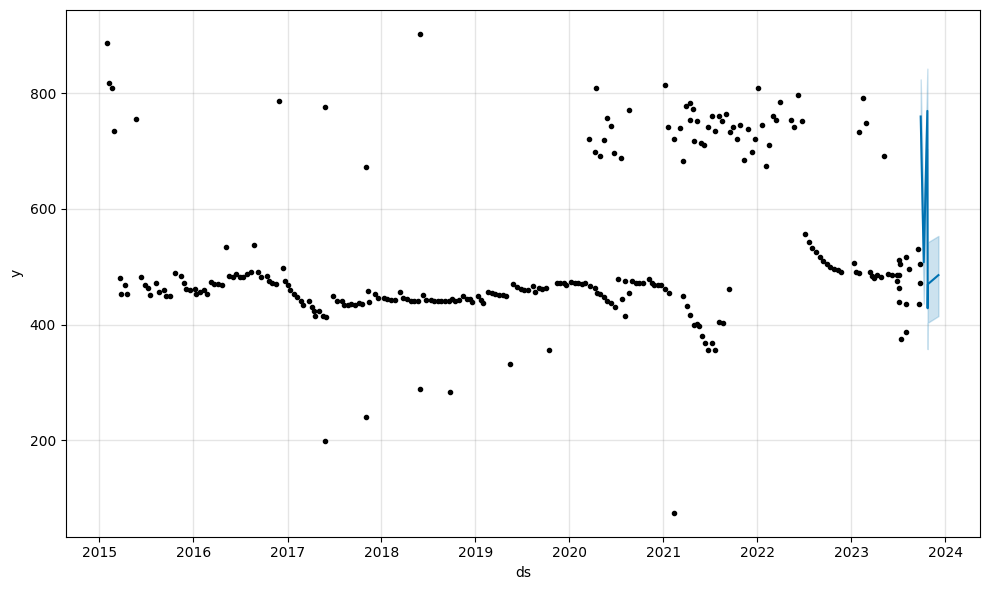

In [44]:
fig1 = m.plot(forecast)


In [45]:
df_clean['Draw_Category'].value_counts()

Draw_Category
No Category Specified                           167
Provincial nominees only                         57
Canadian Experience Class only                   28
Federal Skilled Trades candidates only            7
French language proficiency only                  5
Healthcare occupations only                       3
Foreign Skilled Worker Program nominees only      1
STEM occupations only                             1
Trades occupations only                           1
Transport occupations only                        1
Agriculture and Agri-Food occupations only        1
Name: count, dtype: int64

In [46]:
df_clean.head(2)

,Date,Draw_Category,CRS,Invitations,Year,Month,Month_name,Date_only,Quater
0,2015-01-31,No Category Specified,886,779,2015,1,January,31,1
1,2015-02-07,No Category Specified,818,779,2015,2,February,7,1


In [47]:
monthly_df = df_clean[df_clean['Draw_Category'] == 'No Category Specified'].groupby(['Year','Month'],)['CRS'].mean().reset_index()
monthly_df

,Year,Month,CRS
0,2015,1,886.0
1,2015,2,776.5
2,2015,3,467.0
3,2015,4,461.0
4,2015,5,755.0
...,...,...,...
79,2023,7,508.0
80,2023,8,506.5
81,2023,9,517.5
82,2023,10,500.0


In [48]:
monthly_df['ds'] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(day=1))


In [49]:
prophet_monthly = monthly_df[['ds','CRS']].copy()
prophet_monthly.rename(columns={'CRS' : 'y'},inplace=True)

In [50]:
prophet_monthly

,ds,y
0,2015-01-01,886.0
1,2015-02-01,776.5
2,2015-03-01,467.0
3,2015-04-01,461.0
4,2015-05-01,755.0
...,...,...
79,2023-07-01,508.0
80,2023-08-01,506.5
81,2023-09-01,517.5
82,2023-10-01,500.0


## Prophet Monthly Prediction

In [51]:
test_period = 20


from prophet import Prophet
m = Prophet()
# for col in prophet_reg:
#     m.add_regressor(col)
# # m.add_regressor('Draw_Category_Canadian Experience Class only')
# # m.add_regressor('Draw_Category_Federal Skilled Trades candidates only')
# # m.add_regressor('Draw_Category_French language proficiency only')
# # m.add_regressor('Draw_Category_Healthcare occupations only')
# # m.add_regressor('Draw_Category_No Category')
# # m.add_regressor('Draw_Category_Provincial nominees only')

m.fit(prophet_monthly[:-test_period])

# Python
forecast = m.predict(prophet_monthly[-test_period:])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()





17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
15,2023-07-01,399.121324,324.859556,471.847615
16,2023-08-01,406.770860,329.097717,484.171595
17,2023-09-01,410.354968,335.701757,487.570976
18,2023-10-01,419.641206,339.494432,496.127598
19,2023-12-01,413.983100,333.878193,492.523431


In [52]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(prophet_monthly['y'][-test_period:], forecast['yhat'])
print('mse :',mse)
rmse = np.sqrt(mse)
print('rmse :',rmse)
r2_score_ = r2_score(prophet_monthly['y'][-test_period:].to_list(), forecast['yhat'].to_list())
print('r2_score :',r2_score_)




mse : 7233.994492844342
rmse : 85.05289232497823
r2_score : -11.114635272086115


In [53]:
len(prophet_monthly['y'][-test_period:].to_list())

20

# Regression

## Version 1

Version that directly predicts CRS scores without Invitations

In [54]:
infrequent_draws = model_df['Draw_Category'].value_counts()[model_df['Draw_Category'].value_counts() <=1  ].index.to_list()

In [55]:
onehotencoded_cols

['Draw_Category_No Category Specified',
 'Draw_Category_Canadian Experience Class only',
 'Draw_Category_Provincial nominees only',
 'Draw_Category_Federal Skilled Trades candidates only',
 'Draw_Category_Foreign Skilled Worker Program nominees only',
 'Draw_Category_Healthcare occupations only',
 'Draw_Category_STEM occupations only',
 'Draw_Category_French language proficiency only',
 'Draw_Category_Trades occupations only',
 'Draw_Category_Transport occupations only',
 'Draw_Category_Agriculture and Agri-Food occupations only']

In [56]:
model_df[['Year','CRS','Month','Quater','Draw_Category', *onehotencoded_cols]]


,Year,CRS,Month,Quater,Draw_Category,Draw_Category_No Category Specified,Draw_Category_Canadian Experience Class only,Draw_Category_Provincial nominees only,Draw_Category_Federal Skilled Trades candidates only,Draw_Category_Foreign Skilled Worker Program nominees only,Draw_Category_Healthcare occupations only,Draw_Category_STEM occupations only,Draw_Category_French language proficiency only,Draw_Category_Trades occupations only,Draw_Category_Transport occupations only,Draw_Category_Agriculture and Agri-Food occupations only
0,2015,886,1,1,No Category Specified,1,0,0,0,0,0,0,0,0,0,0
1,2015,818,2,1,No Category Specified,1,0,0,0,0,0,0,0,0,0,0
2,2015,808,2,1,Canadian Experience Class only,0,1,0,0,0,0,0,0,0,0,0
3,2015,735,2,1,No Category Specified,1,0,0,0,0,0,0,0,0,0,0
4,2015,481,3,1,No Category Specified,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2023,500,10,4,No Category Specified,1,0,0,0,0,0,0,0,0,0,0
268,2023,776,10,4,Provincial nominees only,0,0,1,0,0,0,0,0,0,0,0
269,2023,486,10,4,French language proficiency only,0,0,0,0,0,0,0,1,0,0,0
270,2023,431,10,4,Healthcare occupations only,0,0,0,0,0,1,0,0,0,0,0


In [57]:
reg_df = model_df[['Year','CRS','Month','Quater','Draw_Category', *onehotencoded_cols]]
# reg_df = reg_df[~reg_df['Draw_Category'].isin(infrequent_draws)]
reg_df = reg_df.drop(columns=['Draw_Category'])

x_train , x_test, y_train , y_test =  train_test_split(reg_df.drop(columns = ['CRS']),  reg_df['CRS'], test_size = 0.2, random_state=42)

models = {
    'XGB Regressor' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet Regression': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'Decision Tree Regression': DecisionTreeRegressor(max_depth=2),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, max_depth=2)
}

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("CRS Score Prediction")

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model Name: {name}')
    mse = mean_squared_error(y_test,y_pred)
    print(f'MSE : {mse}')
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(f'RMSE : {rmse}')
    MAE = np.sqrt(mean_absolute_error(y_test,y_pred))
    print(f'MAE : {MAE}')
    MAPE = np.sqrt(mean_absolute_percentage_error(y_test,y_pred))
    print(f'MAPE : {MAPE}')
    r2_score_ = r2_score(y_test,y_pred)
    print(f'r2_score : {round(r2_score_,2)}')
    # Start an MLflow run
    with mlflow.start_run(run_name = f'C1 {name} Prediction'):
        # # Log the hyperparameters
        # mlflow.log_params(params)
        # Log the loss metric
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", MAE)
        mlflow.log_metric("MAPE", MAPE)
        mlflow.log_metric("r2_score", round(r2_score_,2))
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", "CRS Prediction without Invitations and Day")
        # Infer the model signature
        signature = infer_signature(x_train, model.predict(x_train))
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="crs_model",
            signature=signature,
            input_example=x_train,
            registered_model_name= f'C1 {name}',
        )



Model Name: XGB Regressor
MSE : 404.4665359774435
RMSE : 20.111353409888743
MAE : 3.733959984308564
MAPE : 0.15682524025755182
r2_score : 0.97


Registered model 'C1 XGB Regressor' already exists. Creating a new version of this model...
2023/12/14 17:31:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 XGB Regressor, version 11
Created version '11' of model 'C1 XGB Regressor'.


Model Name: Linear Regression
MSE : 1592.5319217546278
RMSE : 39.90653983690678
MAE : 5.496173729718094
MAPE : 0.2471303951775539
r2_score : 0.88


Registered model 'C1 Linear Regression' already exists. Creating a new version of this model...
2023/12/14 17:31:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 Linear Regression, version 11
Created version '11' of model 'C1 Linear Regression'.


Model Name: Ridge Regression
MSE : 1407.2134073858663
RMSE : 37.51284323249661
MAE : 5.444075689175866
MAPE : 0.24649196829906658
r2_score : 0.89


Registered model 'C1 Ridge Regression' already exists. Creating a new version of this model...
2023/12/14 17:31:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 Ridge Regression, version 11
Created version '11' of model 'C1 Ridge Regression'.


Model Name: Lasso Regression
MSE : 1372.4273690928026
RMSE : 37.04628684622526
MAE : 5.415527979588667
MAPE : 0.24567093765740158
r2_score : 0.9


Registered model 'C1 Lasso Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 Lasso Regression, version 11
Created version '11' of model 'C1 Lasso Regression'.


Model Name: ElasticNet Regression
MSE : 6685.090253104929
RMSE : 81.76240121905012
MAE : 7.9152229613789435
MAPE : 0.35038720360737247
r2_score : 0.5


Registered model 'C1 ElasticNet Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 ElasticNet Regression, version 11
Created version '11' of model 'C1 ElasticNet Regression'.


Model Name: Support Vector Regression
MSE : 15377.283163935837
RMSE : 124.00517394018621
MAE : 8.734772604220785
MAPE : 0.3575649510030068
r2_score : -0.15


Registered model 'C1 Support Vector Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 Support Vector Regression, version 11
Created version '11' of model 'C1 Support Vector Regression'.


Model Name: Decision Tree Regression
MSE : 2386.7437740478044
RMSE : 48.854311724225575
MAE : 5.943084763922319
MAPE : 0.27267503409713045
r2_score : 0.82


Registered model 'C1 Decision Tree Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 Decision Tree Regression, version 11
Created version '11' of model 'C1 Decision Tree Regression'.


Model Name: Random Forest Regression
MSE : 1386.1755646494066
RMSE : 37.23137876374452
MAE : 5.327071653774465
MAPE : 0.2426232706529172
r2_score : 0.9


Registered model 'C1 Random Forest Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: C1 Random Forest Regression, version 11
Created version '11' of model 'C1 Random Forest Regression'.


In [58]:
x_test.shape

(55, 14)

In [59]:
import pickle
model_v1 = XGBRegressor()
model_v1.fit(x_train, y_train)

filename = 'saved_models/CRS_pred_with_xgb.sav'
pickle.dump(model_v1, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
model_v1_ = pickle.load(open(filename, 'rb'))
y_pred = model_v1_.predict(x_test)
print(f'Model Name: XGBRegressor')
mse = mean_squared_error(y_test,y_pred)
print(f'MSE : {mse}')
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE : {rmse}')
MAE = np.sqrt(mean_absolute_error(y_test,y_pred))
print(f'MAE : {MAE}')
MAPE = np.sqrt(mean_absolute_percentage_error(y_test,y_pred))
print(f'MAPE : {MAPE}')
r2_score_ = r2_score(y_test,y_pred)
print(f'r2_score : {round(r2_score_,2)}')

Model Name: XGBRegressor
MSE : 404.4665359774435
RMSE : 20.111353409888743
MAE : 3.733959984308564
MAPE : 0.15682524025755182
r2_score : 0.97


## Results with Hyperparmter Tuning

In [60]:
# from sklearn.model_selection import RandomizedSearchCV

# hyperparameters = {
#     'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'min_child_weight': [1, 2, 3, 4, 5, 6],
#     'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
#     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
#     'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
#     'reg_lambda': [0, 1, 2, 3, 4, 5],
#     'reg_alpha': [0, 1, 2, 3, 4, 5]
# }

# # Random search of parameters, using 5 fold cross validation, 
# # search across 100 different combinations
# xgb_random = RandomizedSearchCV(estimator = XGBRegressor(), param_distributions = hyperparameters 
# ,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
# xgb_random.fit(x_train,y_train)

# best_hyperparameters = xgb_random.best_params_
# best_hyperparameters

# from xgboost import XGBRegressor


# xgb_reg = XGBRegressor(**best_hyperparameters)
# xgb_reg.fit(x_train, y_train)
# y_pred = xgb_reg.predict(x_test)

# from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, mean_absolute_percentage_error
# mse = mean_squared_error(y_test,y_pred)
# print(f'MSE : {mse}')
# rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# print(f'RMSE : {rmse}')
# MAE = np.sqrt(mean_absolute_error(y_test,y_pred))
# print(f'MAE : {rmse}')
# rmse = np.sqrt(mean_absolute_percentage_error(y_test,y_pred))
# print(f'MAPE : {rmse}')
# r2_score_ = r2_score(y_test,y_pred)
# print(f'r2_score : {round(r2_score_,2)}')

# # metrics_df.loc[5,'algorithm'] = 'Tuned XGBRegressor'
# # metrics_df.loc[5,'model'] = xgb_reg
# # metrics_df.loc[5,'r2_score'] = r2_score
# # metrics_df.loc[5,'mse'] = mse
# # metrics_df.loc[5,'rmse'] = rmse


## XGB Version 2 with Invitations

Version that predicts Invitations scores with CRS

In [61]:
reg_df = model_df[['Year','CRS','Month','Invitations','Quater','Draw_Category', *onehotencoded_cols]]
# reg_df = reg_df[~reg_df['Draw_Category'].isin(infrequent_draws)].drop(columns=['Draw_Category'])
reg_df = reg_df.drop(columns=['Draw_Category'])


from sklearn.model_selection import train_test_split
x_train , x_test, y_train , y_test =  train_test_split(reg_df.drop(columns = ['Invitations']),  reg_df['Invitations'], test_size = 0.2,random_state=42)

from xgboost import XGBRegressor

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Invitations Prediction")

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model Name: {name}')
    mse = mean_squared_error(y_test,y_pred)
    print(f'MSE : {mse}')
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(f'RMSE : {rmse}')
    MAE = np.sqrt(mean_absolute_error(y_test,y_pred))
    print(f'MAE : {MAE}')
    MAPE = np.sqrt(mean_absolute_percentage_error(y_test,y_pred))
    print(f'MAPE : {MAPE}')
    r2_score_ = r2_score(y_test,y_pred)
    print(f'r2_score : {round(r2_score_,2)}')
    # Start an MLflow run
    with mlflow.start_run(run_name = f'I1 {name} Prediction'):
        # # Log the hyperparameters
        # mlflow.log_params(params)
        # Log the loss metric
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", MAE)
        mlflow.log_metric("MAPE", MAPE)
        mlflow.log_metric("r2_score", round(r2_score_,2))
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", "# Invitations Prediction with CRS")
        # Infer the model signature
        signature = infer_signature(x_train, model.predict(x_train))
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="invitations_model",
            signature=signature,
            input_example=x_train,
            registered_model_name= f'I1 {name}',
        )



Model Name: XGB Regressor
MSE : 180851.08022580226
RMSE : 425.26589356049027
MAE : 17.14837375738826
MAPE : 0.5340514532572458
r2_score : 0.93


Registered model 'I1 XGB Regressor' already exists. Creating a new version of this model...
2023/12/14 17:32:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 XGB Regressor, version 7
Created version '7' of model 'I1 XGB Regressor'.


Model Name: Linear Regression
MSE : 793694.0895709627
RMSE : 890.8951058182791
MAE : 25.200001352590302
MAPE : 0.7851084414072944
r2_score : 0.7


Registered model 'I1 Linear Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 Linear Regression, version 7
Created version '7' of model 'I1 Linear Regression'.


Model Name: Ridge Regression
MSE : 777520.5432268847
RMSE : 881.7712533457216
MAE : 25.01831980153347
MAPE : 0.7663600906496324
r2_score : 0.7


Registered model 'I1 Ridge Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 Ridge Regression, version 7
Created version '7' of model 'I1 Ridge Regression'.


Model Name: Lasso Regression
MSE : 791900.4188671849
RMSE : 889.8878687043581
MAE : 25.177019637904152
MAPE : 0.7826996035001663
r2_score : 0.7


Registered model 'I1 Lasso Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 Lasso Regression, version 7
Created version '7' of model 'I1 Lasso Regression'.


Model Name: ElasticNet Regression
MSE : 1449165.7355146126
RMSE : 1203.8129985652308
MAE : 28.840448863677217
MAPE : 1.036539648467629
r2_score : 0.45


Registered model 'I1 ElasticNet Regression' already exists. Creating a new version of this model...
2023/12/14 17:32:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 ElasticNet Regression, version 7
Created version '7' of model 'I1 ElasticNet Regression'.


Model Name: Support Vector Regression
MSE : 2766477.1425468074
RMSE : 1663.2730210482005
MAE : 37.968032528911536
MAPE : 1.2773130846462077
r2_score : -0.06


Registered model 'I1 Support Vector Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 Support Vector Regression, version 7
Created version '7' of model 'I1 Support Vector Regression'.


Model Name: Decision Tree Regression
MSE : 1807292.8170518742
RMSE : 1344.355911599259
MAE : 31.580419779858374
MAPE : 0.982763012734015
r2_score : 0.31


Registered model 'I1 Decision Tree Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 Decision Tree Regression, version 7
Created version '7' of model 'I1 Decision Tree Regression'.


Model Name: Random Forest Regression
MSE : 1378580.0627189076
RMSE : 1174.1294914611879
MAE : 27.917084043035324
MAPE : 0.9409818835416958
r2_score : 0.47


Registered model 'I1 Random Forest Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I1 Random Forest Regression, version 7
Created version '7' of model 'I1 Random Forest Regression'.


Version that predicts Invitations scores without CRS

In [62]:
reg_df = model_df[['Year','Month','Invitations','Quater','Draw_Category', *onehotencoded_cols]]
# reg_df = reg_df[~reg_df['Draw_Category'].isin(infrequent_draws)].drop(columns=['Draw_Category'])
reg_df = reg_df.drop(columns=['Draw_Category'])



from sklearn.model_selection import train_test_split
x_train , x_test, y_train , y_test =  train_test_split(reg_df.drop(columns = ['Invitations']),  reg_df['Invitations'], test_size = 0.2,random_state=42)


mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Invitations Prediction")

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model Name: {name}')
    mse = mean_squared_error(y_test,y_pred)
    print(f'MSE : {mse}')
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(f'RMSE : {rmse}')
    MAE = np.sqrt(mean_absolute_error(y_test,y_pred))
    print(f'MAE : {MAE}')
    MAPE = np.sqrt(mean_absolute_percentage_error(y_test,y_pred))
    print(f'MAPE : {MAPE}')
    r2_score_ = r2_score(y_test,y_pred)
    print(f'r2_score : {round(r2_score_,2)}')
    # Start an MLflow run
    with mlflow.start_run(run_name = f'I2 {name} Prediction wo CRS'):
        # # Log the hyperparameters
        # mlflow.log_params(params)
        # Log the loss metric
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", MAE)
        mlflow.log_metric("MAPE", MAPE)
        mlflow.log_metric("r2_score", round(r2_score_,2))
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", "# Invitations Prediction without CRS")
        # Infer the model signature
        signature = infer_signature(x_train, model.predict(x_train))
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="invitations_model",
            signature=signature,
            input_example=x_train,
            registered_model_name=f'I2 {name}' ,
        )



Model Name: XGB Regressor
MSE : 156683.4980824006
RMSE : 395.83266424387034
MAE : 15.560892332503663
MAPE : 0.48519547658051976
r2_score : 0.94


Registered model 'I2 XGB Regressor' already exists. Creating a new version of this model...
2023/12/14 17:33:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 XGB Regressor, version 7
Created version '7' of model 'I2 XGB Regressor'.


Model Name: Linear Regression
MSE : 930640.4648540147
RMSE : 964.6970845058124
MAE : 24.82659996982342
MAPE : 0.7551543038477002
r2_score : 0.64


Registered model 'I2 Linear Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 Linear Regression, version 7
Created version '7' of model 'I2 Linear Regression'.


Model Name: Ridge Regression
MSE : 926140.1143432453
RMSE : 962.3617377801578
MAE : 24.985154884712667
MAPE : 0.7613291068683772
r2_score : 0.65


Registered model 'I2 Ridge Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 Ridge Regression, version 7
Created version '7' of model 'I2 Ridge Regression'.


Model Name: Lasso Regression
MSE : 927258.3684700024
RMSE : 962.9425572016238
MAE : 24.795402828631737
MAPE : 0.7505680646114796
r2_score : 0.65


Registered model 'I2 Lasso Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 Lasso Regression, version 7
Created version '7' of model 'I2 Lasso Regression'.


Model Name: ElasticNet Regression
MSE : 1858568.0204215336
RMSE : 1363.293079429927
MAE : 34.223173592061784
MAPE : 1.136340308400916
r2_score : 0.29


Registered model 'I2 ElasticNet Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 ElasticNet Regression, version 7
Created version '7' of model 'I2 ElasticNet Regression'.


Model Name: Support Vector Regression
MSE : 2768528.2448394326
RMSE : 1663.8894929770524
MAE : 37.97463253985642
MAPE : 1.277630582564642
r2_score : -0.06


Registered model 'I2 Support Vector Regression' already exists. Creating a new version of this model...
2023/12/14 17:33:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 Support Vector Regression, version 7
Created version '7' of model 'I2 Support Vector Regression'.


Model Name: Decision Tree Regression
MSE : 1373554.2748350147
RMSE : 1171.9873185470117
MAE : 26.878616348185382
MAPE : 0.9544687612008476
r2_score : 0.47


Registered model 'I2 Decision Tree Regression' already exists. Creating a new version of this model...
2023/12/14 17:34:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 Decision Tree Regression, version 7
Created version '7' of model 'I2 Decision Tree Regression'.


Model Name: Random Forest Regression
MSE : 1134310.4325404612
RMSE : 1065.0401084186742
MAE : 25.750525669616025
MAPE : 0.8840851178156238
r2_score : 0.57


Registered model 'I2 Random Forest Regression' already exists. Creating a new version of this model...
2023/12/14 17:34:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: I2 Random Forest Regression, version 7
Created version '7' of model 'I2 Random Forest Regression'.


In [63]:



import pickle
model_v1 = XGBRegressor()
model_v1.fit(x_train, y_train)
filename = 'saved_models/Invitations_pred_with_xgb.sav'
pickle.dump(model_v1, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
model_v1_ = pickle.load(open(filename, 'rb'))
y_pred = model_v1_.predict(x_test)
print(f'Model Name: XGBRegressor')
mse = mean_squared_error(y_test,y_pred)
print(f'MSE : {mse}')
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE : {rmse}')
MAE = np.sqrt(mean_absolute_error(y_test,y_pred))
print(f'MAE : {MAE}')
MAPE = np.sqrt(mean_absolute_percentage_error(y_test,y_pred))
print(f'MAPE : {MAPE}')
r2_score_ = r2_score(y_test,y_pred)
print(f'r2_score : {round(r2_score_,2)}')

Model Name: XGBRegressor
MSE : 156683.4980824006
RMSE : 395.83266424387034
MAE : 15.560892332503663
MAPE : 0.48519547658051976
r2_score : 0.94
